# Argument Intent Linter

The previous notebooks have all focused on using Loki to perform code transformations. Loki can also be used as a Fortran linter. In this notebook, we will use Loki to check whether the declared intent of a subroutine argument is consistent with how that variable is used.

For brevity, only the core functionality of a subroutine dummy argument intent-linter is developed here.

Let us start by first examining the sample subroutine that we will use to illustrate this notebook:

In [1]:
from loki import Sourcefile

source = Sourcefile.from_file('src/intent_test.F90')
print(source.to_fortran())


MODULE kernel_mod
  USE parkind1, ONLY: jpim, jprb
  IMPLICIT NONE
  CONTAINS
  SUBROUTINE some_kernel (n, vout, var_out, var_in, var_inout, b, l, h, y)
    
    INTEGER(KIND=jpim), INTENT(IN) :: n, l, b
    INTEGER(KIND=jpim), INTENT(IN) :: h
    REAL(KIND=jprb), INTENT(IN) :: var_in(n)
    REAL(KIND=jprb), INTENT(INOUT) :: var_out(n)
    REAL(KIND=jprb), INTENT(INOUT) :: var_inout(n)
    REAL(KIND=jprb), INTENT(INOUT) :: vout(n)
    REAL(KIND=jprb), INTENT(INOUT) :: y(:)
    
  END SUBROUTINE some_kernel
END MODULE kernel_mod

SUBROUTINE intent_test (m, n, var_in, var_out, var_inout, tendency_loc)
  USE parkind1, ONLY: jpim, jprb
  USE kernel_mod, ONLY: some_kernel
  USE yoecldp, ONLY: nclv
  IMPLICIT NONE
  
  INTEGER(KIND=jpim), INTENT(IN) :: m, n
  INTEGER(KIND=jpim) :: i, j, k, h, l
  REAL(KIND=jprb), INTENT(IN) :: var_in(n, n, n)
  REAL(KIND=jprb), TARGET, INTENT(OUT) :: var_out(n, n, n)
  REAL(KIND=jprb), INTENT(INOUT) :: var_inout(n, n, n)
  REAL(KIND=jprb), ALLOCATABLE :: x(

## Retrieving variable intent

We can access all the variables declared in subroutine `intent_test` using the `variables` property of the [`Subroutine`](https://sites.ecmwf.int/docs/loki/master/loki.subroutine.html#loki.subroutine.Subroutine) object:

In [2]:
routine = source['intent_test']
print('vars::', ', '.join([str(v) for v in routine.variables]))

vars:: m, n, i, j, k, h, l, var_in(n, n, n), var_out(n, n, n), var_inout(n, n, n), x(:), y(:), vout(n), tendency_loc


In the Loki IR, variables are stored as symbols with base `class` [`MetaSymbol`](https://sites.ecmwf.int/docs/loki/master/loki.expression.symbols.html#loki.expression.symbols.MetaSymbol) and the `intent` of a variable is stored in the `property` [`MetaSymbol.type`](https://sites.ecmwf.int/docs/loki/master/loki.expression.symbols.html#loki.expression.symbols.MetaSymbol.type). To retrieve all variables with declared intent, we only need to look through the `arguments`:

In [3]:
from collections import defaultdict

intent_vars = defaultdict(list)
for var in routine.arguments:
    intent_vars[var.type.intent].append(var)
    
in_vars = intent_vars['in']
out_vars = intent_vars['out']
inout_vars = intent_vars['inout']

print('in::', ', '.join([str(v) for v in in_vars]), 'out::', ', '.join([str(v) for v in out_vars]), 'inout::', ','.join([str(v) for v in inout_vars]))
assert(all([len(in_vars) == 3, len(out_vars) == 2, len(inout_vars) == 1]))

in:: m, n, var_in(n, n, n) out:: var_out(n, n, n), tendency_loc inout:: var_inout(n, n, n)


## Separating variables from dimensions

In Loki, the most general way of retrieving the variables used in an expression or node is the [`FindVariables`](https://sites.ecmwf.int/docs/loki/master/loki.expression.expression.html#loki.expression.expression.FindVariables) visitor. In the IR nodes inside the body of a subroutine, the `FindVariables` visitor will return variables that appear in their own right, as well as any variables used for array indexing. An example of this is seen when `FindVariables` is applied to an [`Allocation`](https://sites.ecmwf.int/docs/loki/master/loki.ir.html#loki.ir.Allocation):

In [4]:
from loki import FindNodes, FindVariables, Allocation

alloc = FindNodes(Allocation).visit(routine.body)[0]
alloc_vars = FindVariables().visit(alloc.variables)
print(', '.join([str(v) for v in alloc_vars]))

n, x(n)


Utilities to distingiush between variables and their dimensions can be constructed by wrapping small functions around `FindVariables`:

In [5]:
from loki import Array, flatten

def findvarsnotdims(o, return_vars=True):
    dims = flatten([FindVariables().visit(var.dimensions) for var in FindVariables().visit(o) if isinstance(var, Array)])

#   remove duplicates from dims
    dims = list(set(dims))

    if return_vars:
        return [var for var in FindVariables().visit(o) if not var in dims]
    else:
        return [var.name for var in FindVariables().visit(o) if not var in dims]
                
def finddimsnotvars(o, return_vars=True):
    dims = flatten([FindVariables().visit(var.dimensions) for var in FindVariables().visit(o) if isinstance(var, Array)])

#   remove duplicates from dims
    dims = list(set(dims))

    if return_vars:
        return [var for var in dims]
    else:
        return [var.name for var in dims]

A quick test reveals:

In [6]:
print(f'vars:{findvarsnotdims(alloc.variables, return_vars=False)}')
print(f'dims:{finddimsnotvars(alloc.variables, return_vars=False)}')

assert(len(findvarsnotdims(alloc.variables)) == 1)
assert(len(finddimsnotvars(alloc.variables)) == 1)

vars:['x']
dims:['n']


## Resolving associations

You may have noticed that `intent_test` contains several nested associations. The simplest way of dealing with these is to resolve all the associations before we begin linting the program:

In [7]:
from loki import fgen, SubstituteExpressions, Associate, Transformer

assoc_map = {}
for assoc in FindNodes(Associate).visit(routine.body):
    for rexpr, lexpr in assoc.associations:
        vmap = {var: rexpr for var in [v for v in FindVariables().visit(assoc.body) if lexpr == v]}

    assoc_map[assoc] = SubstituteExpressions(vmap).visit(assoc.body)
routine.body = Transformer(assoc_map).visit(routine.body)
print(fgen(routine.body))


ALLOCATE (x(n))
ALLOCATE (y(m))

DO k=1,n
  DO j=1,n
    DO i=1,n
      var_out(i, j, k) = 2._jprb
    END DO
    
    var_out(m:n, j, k) = var_in(m:n, j, k) + var_inout(m:n, j, k) + var_out(m:n, j, k)
    
    vout => var_out(:, j, k)
    
    CALL some_kernel(n, vout, vout, var_in(:, j, k), var_inout(:, j, k), 1, h=n, l=5, y=y)
    
    NULLIFY (vout)
    
    
    CALL some_kernel(n, tendency_loc%cld(:, j, k), var_out(:, j, k), var_in(:, j, k), var_inout(:, j, k), 1, h=n, l=5, y=y)
    
    
    DO i=1,n
      var_inout(i, j, k) = var_out(i, j, k)
    END DO
  END DO
END DO

DEALLOCATE (x)
DEALLOCATE (y)



We can perform a similar operation on pointer association using the `=>` operator:

In [8]:
from loki import Assignment, Node, Nullify

pointer_map = {}
for assign in [a for a in FindNodes(Assignment).visit(routine.body) if a.ptr]:
    loc = [k for k, n in enumerate(FindNodes(Node).visit(routine.body)) if n == assign][0]
    assert loc, f'location of pointer {assign} not found'
    
    pointer_map[assign] = None
    for node in FindNodes(Node).visit(routine.body)[loc+1:]:
        if isinstance(node, Nullify) and assign.lhs in findvarsnotdims(getattr(node, "variables", None)):
            pointer_map[node] = None
            break
        
        vmap = {var: assign.rhs for var in [v for v in FindVariables().visit(node) if assign.lhs == v]}
        pointer_map[node] = SubstituteExpressions(vmap).visit(node)

routine.body = Transformer(pointer_map).visit(routine.body)
print(fgen(routine.body))


ALLOCATE (x(n))
ALLOCATE (y(m))

DO k=1,n
  DO j=1,n
    DO i=1,n
      var_out(i, j, k) = 2._jprb
    END DO
    
    var_out(m:n, j, k) = var_in(m:n, j, k) + var_inout(m:n, j, k) + var_out(m:n, j, k)
    
    
    CALL some_kernel(n, var_out(:, j, k), var_out(:, j, k), var_in(:, j, k), var_inout(:, j, k), 1, h=n, l=5, y=y)
    
    
    
    CALL some_kernel(n, tendency_loc%cld(:, j, k), var_out(:, j, k), var_in(:, j, k), var_inout(:, j, k), 1, h=n, l=5, y=y)
    
    
    DO i=1,n
      var_inout(i, j, k) = var_out(i, j, k)
    END DO
  END DO
END DO

DEALLOCATE (x)
DEALLOCATE (y)



You may have noticed in the previous code-cell we used `getattr` to access the `variables` property of `node`, rather than directly trying to access `node.variables`. This is because not every node type has a `variables` property, and trying to access `variables` for such nodes will raise expception. The `getattr` clause allows to side-step this potential problem, and if the property is not found, the third argument to `getattr` is returned (which in this case is `None`).

## Modifying variable values

Putting aside function or subroutine calls for the moment (and also ignoring I/O), there are only two mechanisms for modifying the value of a variable. The obvious one is an [`Assignment`](https://sites.ecmwf.int/docs/loki/master/loki.ir.html#loki.ir.Assignment) statement, where the `rhs` value is assigned to the `lhs` value.

Values can also be assigned to a variable by using it as the induction variable of a loop. Although an extremely unusual practice, Fortran compilers do allow dummy arguments of kind `intent(out)` or `intent(inout)`  to be used as the induction variables of a loop. This is however (in my humble opinion) bad coding practice; for ease of readability, local variables rather than dummy arguments should be used as loop induction variables. Therefore in our linter rules, we will forbid the use of variables with declared `intent` as loop induction variables.

The next section creates linter rules for checking `intent` consistency within the `Subroutine` body. We will later examine how this can be extended to subroutine calls.

## Checking `intent` in `Subroutine` body

Let us first check that variables with declared `intent` are not used as loop induction variables:

In [9]:
from loki import Loop

var_check = {var: True for var in (in_vars+out_vars+inout_vars)}

for loop in FindNodes(Loop).visit(routine.body):
    if loop.variable.type.intent:
        var_check[loop.variable] = False
        
def rule_check(var_check):
    for var, stat in var_check.items():
        assert stat, f'intent({var.type.intent}) rule broken for {var.name}'

rule_check(var_check)

Having confirmed variables with declared `intent` are not used as loop induction variables, we can now check the rest of the subroutine body.

For `intent(in)` variables, we don't want their value to be reassigned in the `Subroutine`. Therefore the rule for checking `intent(in)` variables is the simplest: variables of kind `intent(in)` should not appear in the `lhs` of an `Assignment`:

In [10]:
for assign in FindNodes(Assignment).visit(routine.body):
    var_check.update({var: False for var in in_vars if var in findvarsnotdims(assign.lhs)})
            
rule_check(var_check)

The rule for `intent(out)` variables is that upon entry to a subroutine, a value must be assigned to them before the variable can be used. This means that before its first appearance in the lhs of an `Assignment` statement, the variable in question must not:
- Appear in an [`InternalNode`](https://sites.ecmwf.int/docs/loki/master/internal_representation.html#internal-node-classes) outside of that node's body
- Appear at all in a [`LeafNode`](https://sites.ecmwf.int/docs/loki/master/internal_representation.html#leaf-node-classes)

In [11]:
from loki import CallStatement, LeafNode, InternalNode

for var in out_vars:
    for node in FindNodes((LeafNode, InternalNode)).visit(routine.body):
        if isinstance(node, InternalNode):
            if var in FindVariables().visit(node) and var not in FindVariables().visit(node.body):
                var_check[var] = False
                break
        else:
            if isinstance(node, CallStatement):
                continue
            elif isinstance(node, Assignment):
                if var in FindVariables().visit(node.rhs):
                    var_check[var] = False
                    break
                if var in findvarsnotdims(node.lhs):
                    break
            else:
                if var in FindVariables().visit(node):
                    var_check[var] = False
                    break
            
rule_check(var_check)

You may have noticed that the above code cell does not perform any checks for `CallStatement`. Implementing intent rules for `CallStatement` is more complex than for other types of `LeafNode`, and is explored in the next section of this notebook.

Finally, in principle we could also build similar checks for `intent(inout)` variables. However, the way in which some Fortran compilers treat `allocatable` variables prevents us from doing so.

If an `allocatable` array is passed to a subroutine as a dummy argument of kind `intent(out)`, some Fortran compilers will deallocate that array upon exiting the subroutine. This is why in the IFS, data arrays are sometimes declared as `intent(inout)` even if their true intent is `intent(out)`. An example can be seen in the 'cloudsc-dwarf' in `src/cloudsc_driver_mod.F90`: the `REAL` array `PCOVPTOT` is declared `intent(inout)` even though it's value entering the subroutine is never used.

An allocatable array passed as a dummy argument to a subroutine could thus belong to two possible categories:
1. A variable that is truly of type `intent(inout)`
2. A variable that is strictly of type `intent(out)`, but has been declared `intent(inout)` to avoid deallocation

It would be very difficult to discern between the two options from a static analysis of the source code. As such, we will not impose any rules related to `Assignment` expressions for `intent(inout)` variables.

We can however impose the rule that an `allocatable` array that is passed as a dummy argument must be of kind `intent(inout)` or `intent(in)` in the relevant subroutine:

In [12]:
alloc_vars = flatten([findvarsnotdims(alloc.variables) for alloc in FindNodes(Allocation).visit(routine.body)])

# link Subroutine object with matching call
routine.enrich_calls(source.all_subroutines)

for call in FindNodes(CallStatement).visit(routine.body):
    assert call.routine, f'matching routine for {call} not found'
    
    for arg, carg in call.arg_iter():
        if getattr(carg, "name", None) in [a.name for a in alloc_vars]:
            assert arg.type.intent in ['in', 'inout'], f'Allocatable dummy arg {arg} has wrong intent in {call.routine} declaration'

## Building `intent` map between function caller and callee

Clearly, variables can also be assigned in a function/subroutine call. Whilst our intent linter can easily be applied recursively to examine the body of every called function, we must also ensure that the declared `intent` of a dummy argument is consistent with the `intent` of that variable in the calling (parent) subroutine.

For example, `var_in` is a variable of kind `intent(in)` in `Subroutine` `intent_test`. Therefore `var_in` must not be modified within `intent_test` or any subroutines called by `intent_test`. Hence in `some_kernel`, `var_in` must also be of kind `intent(in)`.

The mapping for `intent(out)` variables is a little more complicated and depends on whether before the `CallStatement`, the variable in question has ever been used, and if so, whether the value last assigned to it been used at least once. The procedure for building the mapping is best illustrated using the flowchart below:

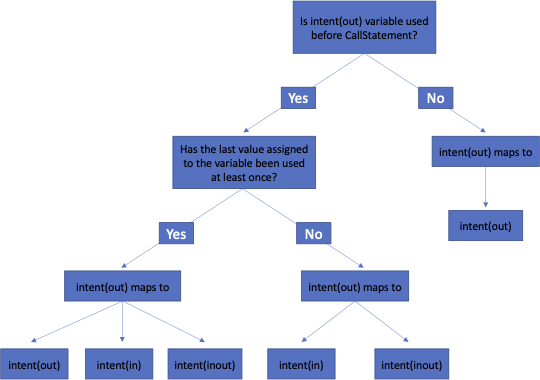

In [13]:
from IPython.display import Image

fig = Image(filename='gfx/intent_out_map-crop.png')
fig

A similar process can be used to determine the mapping for `intent(inout)` variables:

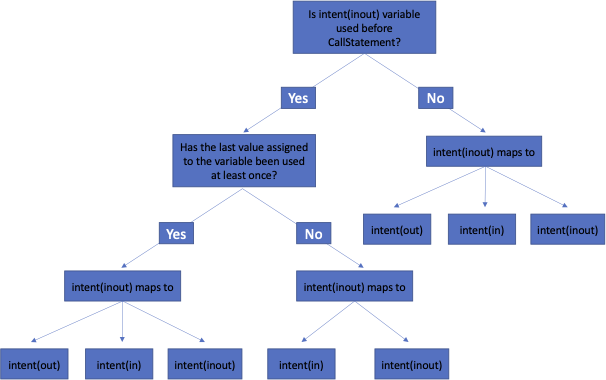

In [14]:
fig = Image(filename='gfx/intent_inout_map-crop.png')
fig

You may be wondering why `intent(out)` has been included as a permitted value for the rightmost tree of the above flowchart. It is to account for the following possibility: an allocatable variable is allocted in subroutine A, and passed as an argument to subroutine B. Subroutine B must therefore declare the variable as either `intent(inout)` or `intent(in)`. Subroutine B then passes the variable as an argument to subroutine C without using in the subroutine body beforehand. In subroutine C, the variable can correctly be of any declared intent.

## Checking `intent` consistency across function calls

The code below gives an example of how checking the `intent` consistency across function calls can be implemented:

In [15]:
assign_type = {var.name: 'none' for var in flatten([[a for f, a in call.arg_iter() if hasattr(a, 'type')] for call in FindNodes(CallStatement).visit(routine.body)])}
assert len(assign_type) == 6

intent_map = {'in': {'none': ['in'], 'lhs': ['in'], 'rhs': ['in']}}
intent_map['out'] = {'none': ['out'], 'lhs': ['in', 'inout'], 'rhs': ['in', 'inout', 'out']}
intent_map['inout'] = {'none': ['in', 'inout', 'out'], 'lhs': ['in', 'inout'], 'rhs': ['in', 'inout', 'out']}

loc = [c for c, node in enumerate(FindNodes(Node).visit(routine.body)) if isinstance(node, CallStatement)]
for node in FindNodes(Node).visit(routine.body)[:loc[-1]+1]:
    if isinstance(node, CallStatement):
        for f, a in [(f, a) for f, a in node.arg_iter() if getattr(getattr(a, 'type', None), 'intent', None)]:
            assert f.type.intent in intent_map[a.type.intent][assign_type[a.name]], f'Inconsistent intent in {node} for arg {a.name}'

    for arg in assign_type:
        if isinstance(node,Assignment):
            if arg in findvarsnotdims(node.lhs,return_vars=False):
                assign_type[arg] = 'lhs'
            elif arg in [v.name for v in FindVariables().visit(node.rhs)]:
                assign_type[arg] = 'rhs'
        elif isinstance(node,LeafNode):
            if arg in [v.name for v in FindVariables().visit(node)]:
                assign_type[arg] = 'rhs'
        elif isinstance(node,InternalNode):
            if arg in [v.name for v in FindVariables().visit(node)] and not arg in [v.name for v in FindVariables().visit(node.body)]:
                assign_type[arg] = 'rhs'

The above code-cell starts by initializing a dict of only the non-literal arguments of all the subroutine calls. This is achieved by checking for the presence of the `type` attribute. We then use a two-level dict to build a mapping of allowed intents for subroutine arguments. Finally, we loop through the IR tree up to and including the last `CallStatement` and check the intent consistency of each subroutine argument.